###### Importing Dependencies

In [34]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

###### Extracting Today's Most Viewed Pages

In [11]:
from datetime import datetime, timedelta
import requests

def fetch_wikipedia_top_views(date=None):
    if date is None:
        # Always fetch yesterday's fully available data
        date = datetime.today() - timedelta(days=1)

    year = date.strftime("%Y")
    month = date.strftime("%m")
    day = date.strftime("%d")

    url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/{year}/{month}/{day}"

    headers = {
        "User-Agent": "WikipediaTrendingETL/1.0 (bestmankingsley001@gmail.com)"
    }

    print("Fetching:", url)
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        raise Exception("API Error:", response.text)

    return response.json()


In [12]:
#testing the function
raw_data = fetch_wikipedia_top_views()
raw_data["items"][0]["articles"][:5] 


Fetching: https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/2025/11/16


[{'article': 'Main_Page', 'views': 6117318, 'rank': 1},
 {'article': 'Special:Search', 'views': 843078, 'rank': 2},
 {'article': 'Troy_Parrott', 'views': 364546, 'rank': 3},
 {'article': '2026_FIFA_World_Cup_qualification_(UEFA)',
  'views': 341058,
  'rank': 4},
 {'article': 'UFC_322', 'views': 316030, 'rank': 5}]

###### Saving Raw Json

In [25]:
def store_raw_json(data, date=None):
    if date is None:
        date = datetime.today()

    folder = "Trending Topics ETL System(Wikipedia)/data/Raw"
    os.makedirs(folder, exist_ok=True)

    filename = f"{folder}/{date.strftime('%Y-%m-%d')}.json"

    with open(filename, "w", encoding="utf-8") as f:
        import json
        json.dump(data, f, indent=2)

    return filename

store_raw_json(raw_data)


'Trending Topics ETL System(Wikipedia)/Data/Raw/2025-11-17.json'

###### Transforming and Cleaning

In [15]:
def transform_data(raw_json):
    articles = raw_json["items"][0]["articles"]

    df = pd.DataFrame(articles)
    df = df[["rank", "article", "views"]]

    # Clean article names
    df["article"] = df["article"].str.replace("_", " ")

    return df


In [16]:
df_today = transform_data(raw_data)
df_today.head()


,rank,article,views
0,1,Main Page,6117318
1,2,Special:Search,843078
2,3,Troy Parrott,364546
3,4,2026 FIFA World Cup qualification (UEFA),341058
4,5,UFC 322,316030


In [17]:
df_today.shape

(1000, 3)

######  Saving Processed data

In [26]:
def store_processed_data(df, date=None):
    if date is None:
        date = datetime.today()

    folder = "Trending Topics ETL System(Wikipedia)/data/processed"
    os.makedirs(folder, exist_ok=True)

    filename = f"{folder}/{date.strftime('%Y-%m-%d')}.csv"
    df.to_csv(filename, index=False)

    return filename

store_processed_data(df_today)


'Trending Topics ETL System(Wikipedia)/Data/processed/2025-11-17.csv'

###### Building a small historical dashboard

In [19]:
import glob

files = sorted(glob.glob("data/processed/*.csv"))

final_df = []
for f in files:
    temp = pd.read_csv(f)
    temp["date"] = os.path.basename(f).replace(".csv", "")
    final_df.append(temp)

history = pd.concat(final_df)
history.head()


,rank,article,views,date
0,1,Main Page,6117318,2025-11-17
1,2,Special:Search,843078,2025-11-17
2,3,Troy Parrott,364546,2025-11-17
3,4,2026 FIFA World Cup qualification (UEFA),341058,2025-11-17
4,5,UFC 322,316030,2025-11-17


###### Analysing trends over time

In [31]:
# 5 most frequent pages
trend = history.groupby("article")["views"].sum().sort_values(ascending=False).head(5)
trend

article
Main Page                                   6117318
Special:Search                               843078
Troy Parrott                                 364546
2026 FIFA World Cup qualification (UEFA)     341058
UFC 322                                      316030
Name: views, dtype: int64

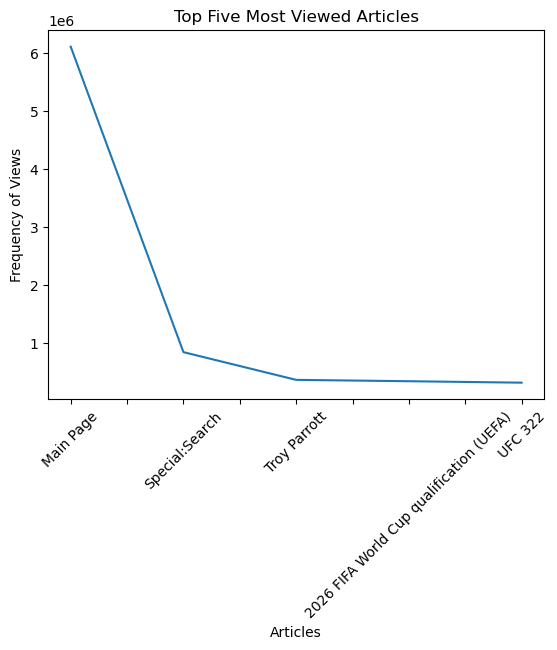

In [37]:
#visualizing trends
trend.plot(kind = "line")
plt.title("Top Five Most Viewed Articles")
plt.ylabel("Frequency of Views")
plt.xlabel("Articles")
plt.xticks(rotation = 45)
plt.show()

In [28]:
history[history["article"].str.contains("YouTube", case=False)].head(10)

,rank,article,views,date
46,47,Jack Doherty (YouTuber),75848,2025-11-17
93,94,YouTube,46280,2025-11-17


###### Top ten most viewed articles over time

In [43]:
top_articles = (
    history.groupby("article")["views"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_articles_df = top_articles.reset_index()
top_articles_df.columns = ["article", "total_views"]
top_articles_df


,article,total_views
0,Main Page,6117318
1,Special:Search,843078
2,Troy Parrott,364546
3,2026 FIFA World Cup qualification (UEFA),341058
4,UFC 322,316030
5,Google Chrome,282558
6,2026 FIFA World Cup qualification,251048
7,Wikipedia:Featured pictures,238719
8,Islam Makhachev,233435
9,Dillon Danis,165285


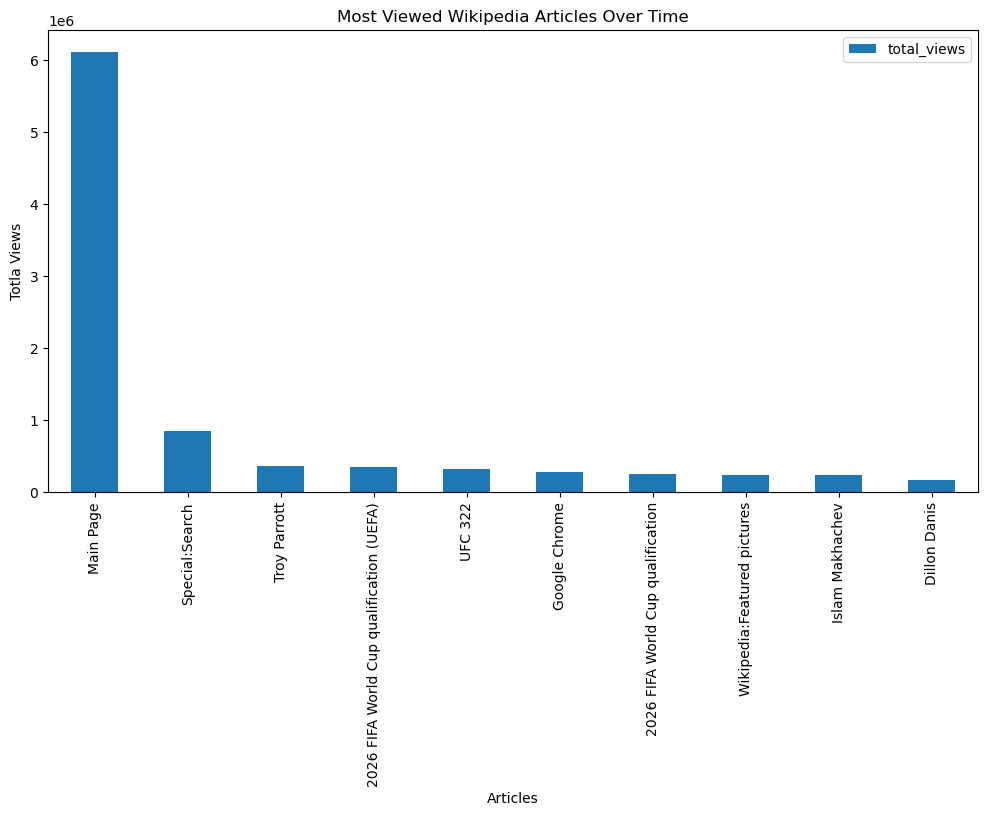

In [47]:
top_articles_df.plot(
    x="article",
    y="total_views",
    kind="bar",
    figsize=(12,6),
    title="Most Viewed Wikipedia Articles Over Time"
)

plt.xlabel("Articles")
plt.ylabel("Totla Views")
plt.show()